In [1]:
%pylab inline
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
import cartopy
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import math as math
import matplotlib.animation as animation
from collections import Counter 
sys.path.insert(1, '../../functions/')
from ParticlePlotFunctions import *
import pandas as pd
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [93]:
def variability_beaching(namefile,fieldtype='beaching'):
    """This function returns the number of particles beaching at each island per month"""

    Traj = ReadTrajectories(namefile)
    total_particles = Traj['lon'].shape[0]
    ptime= Traj['time'][:]
    island = Traj['island'][:]

    ptime[isnat(ptime)]=Traj['time'][0,0]
    simtimes = np.arange(np.min(ptime), np.max(ptime), dtype='datetime64[6h]').astype('datetime64[ns]')
    arrivals = np.zeros((11,simtimes.shape[0]))
    
    if fieldtype == 'beaching':
        beached = Traj['beached'][:]
        for p in range(total_particles):
            if beached[p,-1]==1:
                beaching_index = np.where(beached[p,:]==1)[0][0]
                time_index = np.where(simtimes == ptime[p,beaching_index].astype('datetime64[6h]').astype('datetime64[ns]'))[0]
                island_beached = int(island[p,beaching_index])
                arrivals[0,time_index] += 1 
                arrivals[island_beached,time_index] += 1 
    else:
        distance = Traj['distance'][:]
        release_loc = 675   #number of release locations
        distance_from_coast = 4 #in km, threshold for beaching
        for p in range(total_particles):
            index_loc = p%release_loc
            beached = np.where((distance[p,:] < distance_from_coast) & (distance[p,:] != 0))[0]
            if beached.any():
                beaching_index = beached[0]
                time_index = np.where(simtimes == ptime[p,beaching_index].astype('datetime64[6h]').astype('datetime64[ns]'))[0]
                island_beached = int(island[p,beaching_index])
                arrivals[0,time_index] += 1
                arrivals[island_beached,time_index] += 1
                
    data = {'Time': simtimes,
            'Number of particles beaching in total': arrivals[0,:],
            'Number of particles beaching Espanola': arrivals[1,:],
            'Number of particles beaching Floreana': arrivals[2,:],
            'Number of particles beaching Isabela': arrivals[3,:],
            'Number of particles beaching San Cristobal': arrivals[4,:],
            'Number of particles beaching Santa Fe': arrivals[5,:],
            'Number of particles beaching Santa Cruz': arrivals[6,:],
            'Number of particles beaching Fernandina': arrivals[7,:],
            'Number of particles beaching Santiago': arrivals[8,:],
            'Number of particles beaching Marchena': arrivals[9,:],
            'Number of particles beaching Pinta': arrivals[10,:],}

    timeseries = pd.DataFrame(data, columns = ['Time', 
                                               'Number of particles beaching in total', 
                                               'Number of particles beaching Espanola',
                                               'Number of particles beaching Floreana',
                                               'Number of particles beaching Isabela',
                                               'Number of particles beaching San Cristobal',
                                               'Number of particles beaching Santa Fe',
                                               'Number of particles beaching Santa Cruz',
                                               'Number of particles beaching Fernandina', 
                                               'Number of particles beaching Santiago',
                                               'Number of particles beaching Marchena',
                                               'Number of particles beaching Pinta'])
    
    timeseries.Time = pd.to_datetime(timeseries.Time)
    beaching_monthly = timeseries.resample('M', on='Time').sum()
    return beaching_monthly

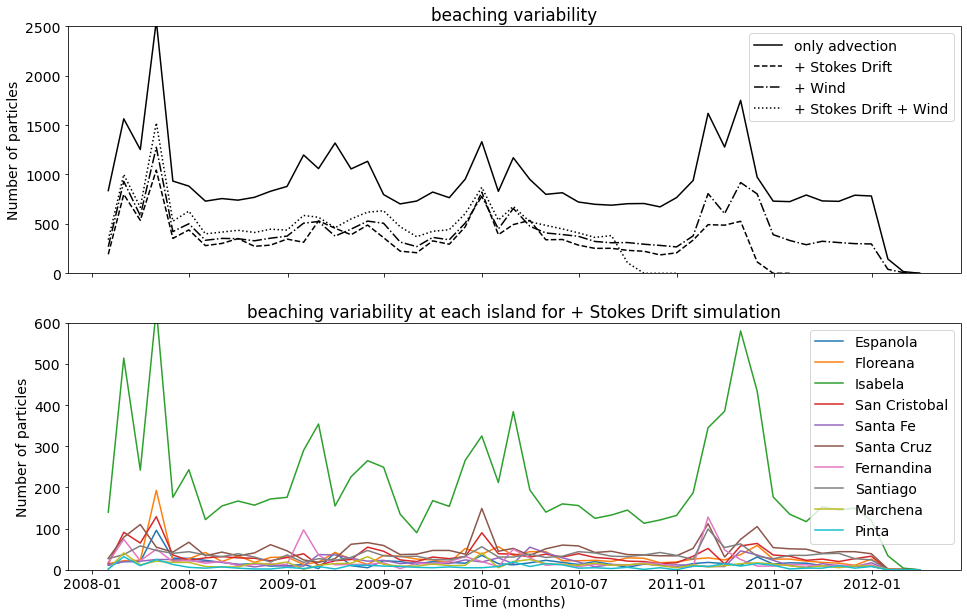

In [107]:
# FIGURE: Beaching variability

filepath = '../../input/particles/Beaching_200826.nc'
onlyadvection_beaching = variability_beaching(filepath,fieldtype='other')
filepath = '../../input/particles/Beaching_200826_wstokes.nc'
stokes_beaching = variability_beaching(filepath)
filepath = '../../input/particles/Beaching_200826_wind0010.nc'
wind_beaching = variability_beaching(filepath)
filepath = '../../input/particles/Beaching_200826_wstokes_wind0010.nc'
all_beaching = variability_beaching(filepath)

figsize=(16,10)
fig, axs = plt.subplots(2, 1, figsize=figsize, sharey = False, sharex = True)
axs = axs.ravel() 

axs[0].plot(onlyadvection_beaching["Number of particles beaching in total"],'-k',label='only advection')
axs[0].plot(stokes_beaching["Number of particles beaching in total"],'--k',label='+ Stokes Drift')
axs[0].plot(wind_beaching["Number of particles beaching in total"],'-.k',label='+ Wind')
axs[0].plot(all_beaching["Number of particles beaching in total"],':k',label='+ Stokes Drift + Wind')
axs[0].legend()
axs[0].set_ylim([0, 2500])
axs[0].set_ylabel('Number of particles')
axs[0].set_title('beaching variability')

axs[1].plot(wind_beaching["Number of particles beaching Espanola"],label='Espanola')
axs[1].plot(wind_beaching["Number of particles beaching Floreana"],label='Floreana')
axs[1].plot(wind_beaching["Number of particles beaching Isabela"],label='Isabela')
axs[1].plot(wind_beaching["Number of particles beaching San Cristobal"],label='San Cristobal')
axs[1].plot(wind_beaching["Number of particles beaching Santa Fe"],label='Santa Fe')
axs[1].plot(wind_beaching["Number of particles beaching Santa Cruz"],label='Santa Cruz')
axs[1].plot(wind_beaching["Number of particles beaching Fernandina"],label='Fernandina')
axs[1].plot(wind_beaching["Number of particles beaching Santiago"],label='Santiago')
axs[1].plot(wind_beaching["Number of particles beaching Marchena"],label='Marchena')
axs[1].plot(wind_beaching["Number of particles beaching Pinta"],label='Pinta')
axs[1].legend()
axs[1].set_ylim([0, 600])
axs[1].set_ylabel('Number of particles')
axs[1].set_xlabel('Time (months)')
axs[1].set_title('beaching variability at each island for + Stokes Drift simulation')

plt.rcParams.update({'font.size': 14})
plt.savefig('variability_arrival.png', dpi = 300)

### Figure on beaching variability

There is clearly a seasonal cycle:
- limited beaching in the months Jul - Aug - Sep (cold/dry season, strong winds and currents)
- enhanced beaching in the months Mar - Apr - May (warm/wet season, weak winds and currents)

Do we expect to have more beaching with strong winds and currents or less?

(Isabela by far largest island so most particles beach there, second figure could be better interpreted when scaled by coastline-length)

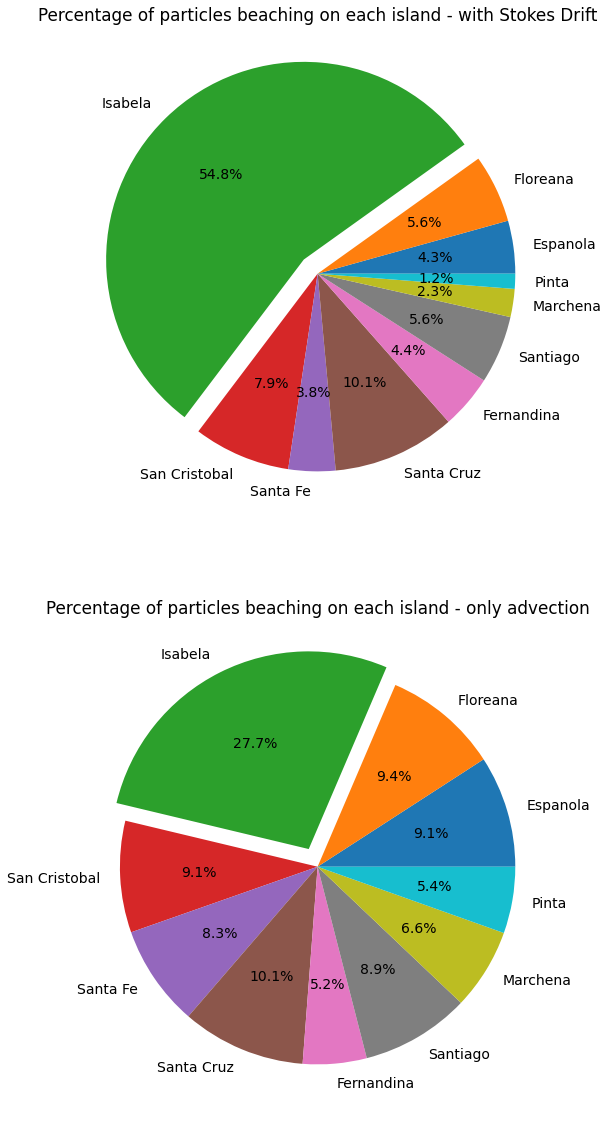

In [125]:
# FIGURE: Pie diagram of how many particles beach in total at each island

labels = 'Espanola', 'Floreana', 'Isabela', 'San Cristobal', 'Santa Fe', 'Santa Cruz', 'Fernandina', 'Santiago', 'Marchena', 'Pinta'
sizes1 = [stokes_beaching["Number of particles beaching Espanola"].sum(), 
         stokes_beaching["Number of particles beaching Floreana"].sum(),
         stokes_beaching["Number of particles beaching Isabela"].sum(),
         stokes_beaching["Number of particles beaching San Cristobal"].sum(),
         stokes_beaching["Number of particles beaching Santa Fe"].sum(),
         stokes_beaching["Number of particles beaching Santa Cruz"].sum(),
         stokes_beaching["Number of particles beaching Fernandina"].sum(),
         stokes_beaching["Number of particles beaching Santiago"].sum(),
         stokes_beaching["Number of particles beaching Marchena"].sum(),
         stokes_beaching["Number of particles beaching Pinta"].sum()]

sizes2 = [onlyadvection_beaching["Number of particles beaching Espanola"].sum(), 
         onlyadvection_beaching["Number of particles beaching Floreana"].sum(),
         onlyadvection_beaching["Number of particles beaching Isabela"].sum(),
         onlyadvection_beaching["Number of particles beaching San Cristobal"].sum(),
         onlyadvection_beaching["Number of particles beaching Santa Fe"].sum(),
         onlyadvection_beaching["Number of particles beaching Santa Cruz"].sum(),
         onlyadvection_beaching["Number of particles beaching Fernandina"].sum(),
         onlyadvection_beaching["Number of particles beaching Santiago"].sum(),
         onlyadvection_beaching["Number of particles beaching Marchena"].sum(),
         onlyadvection_beaching["Number of particles beaching Pinta"].sum()]

explode = (0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0)

figsize=(10,20)
fig, axs = plt.subplots(2, 1, figsize=figsize)
im = axs[0].pie(sizes1, explode = explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=0)
text = axs[0].set_title('Percentage of particles beaching on each island - with Stokes Drift')
im2 = axs[1].pie(sizes2, explode = explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=0)
text = axs[1].set_title('Percentage of particles beaching on each island - only advection')
plt.savefig('arrivalpercentage_per_island.png', dpi = 300)

![link to figure](https://www.orangesmile.com/common/img_city_maps/galapagos-region-map-0.jpg)

In [ ]:
## Make map where particles beach
# need landborder and loop through particles to find closest landborder point and then scatter